In [5]:
from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [6]:
fq = 6.8112 # transmon frequency
fc = 4.0755 # resonator frequency
SBI = 8.63  # Sideband interaction factor, Corresonding to A_{t}^{0.75} x A_{r}^{0.25} in eq 4 in the main text. 
A_t = 150   # transmon anharmonicity.

# SB_bs/rwa : Sideband transition rates.
# SB_dev_bs/rwa : Matching frequency shifts (=Mode frequency shifts).
# rwa : Only rotating driving terms in the simulation.
# cr   : Only counter-rotating driving terms in the simulation.

def SB_bs(fq,fc,SBI,fd,eps):
    return 2*SBI*(eps**2)*(1/(fc+2*fd-fd)**2+1/(fc+2*fd+fd)**2+2/(fc+2*fd-fd)/(fc+2*fd+fd))

def SB_blue(fq,fc,SBI,fd,eps):
    return 2*SBI*eps**2*(1/(2*fd-fc-fd)**2+1/(2*fd-fc+fd)**2+2/(2*fd-fc-fd)/(2*fd-fc+fd))

def SB_bs_dev(fq,fc,SBI,fd,eps):
    return 2*A_t*eps**2*(1/(fc+2*fd-fd)**2+1/(fc+2*fd+fd)**2+2/(fc+2*fd-fd)/(fc+2*fd+fd))

def SB_blue_dev(fq,fc,SBI,fd,eps):
    return 2*A_t*eps**2*(1/(2*fd-fc-fd)**2+1/(2*fd-fc+fd)**2+2/(2*fd-fc-fd)/(2*fd-fc+fd))

def SB_bs_dev_rwa(fq,fc,SBI,fd,eps):
    return 2*A_t*eps**2*(1/(fc+2*fd-fd)**2)

def SB_bs_dev_cr(fq,fc,SBI,fd,eps):
    return 2*A_t*eps**2*(1/(fc+2*fd+fd)**2)

def SB_tms_dev_rwa(fq,fc,SBI,fd,eps):
    return 2*A_t*eps**2*(1/(2*fd-fc-fd)**2)

def SB_bs_rwa(fq,fc,SBI,fd,eps):
    return 2*SBI*eps**2*(1/(fc+2*fd-fd)**2)                                                             

def SB_tms_rwa(fq,fc,SBI,fd,eps):
    return 2*SBI*eps**2*(1/(2*fd-fc-fd)**2)
                                                                
def SB_bs_cr(fq,fc,SBI,fd,eps):
    return 2*SBI*eps**2*(1/(fc+2*fd+fd)**2)    

def SB_tms_cr(fq,fc,SBI,fd,eps):
    return 2*SBI*eps**2*(1/(2*fd-fc+fd)**2)                                                                

In [7]:
sim_eps_bs = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]                # driving strength (half of driving amplitudes)
sim_eps_tms = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]                    # driving strength 
sim_wsb_bs = [0.2690954,0.427,0.614026,0.831796,1.119594, 1.386042,1.737036, 2.11365] # Sideband transition rate.
sim_wsb_tms = [0.479094, 1.100806, 1.950536, 3.143574, 4.62014, 6.43916, 8.3692]      # Sideband transition rate.

# Drive frequencies.
sim_wd_bs = [1.365548,1.3642 ,1.3625,1.3605,1.3585,1.3557,1.3527,1.3494]
sim_wd_tms = [5.43796,5.4322,5.4241,5.4134,5.4,5.384,5.3650]
sim_wd_bs_rwa = [1.3671,1.3666,1.366,1.3653,1.3645,1.3636,1.3626,1.3615]
sim_wd_tms_rwa = [5.4390,5.4344,5.4278,5.4200,5.4093,5.3959,5.3827]
sim_wd_bs_cr = [1.367485,1.36728,1.367,1.3667,1.3664,1.36602,1.3656,1.365]

# Mode frequency shifts.
sim_devdr_bs = 2*np.asarray(sim_wd_bs) - (6.8112-4.0755)         
sim_devdr_tms =  2*np.asarray(sim_wd_tms) - (6.8112+4.0755) 
sim_devdr_bs_rwa = 2*np.asarray(sim_wd_bs_rwa) - (6.8112-4.0755) 
sim_devdr_tms_rwa = 2*np.asarray(sim_wd_tms_rwa) - (6.8112+4.0755) 
sim_devdr_bs_cr = 2*np.asarray(sim_wd_bs_cr) - (6.8112-4.0755) 

# Driving strengths for RWA and CR data.
sim_eps_bs_rwa = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]  
sim_eps_tms_rwa = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  
sim_eps_bs_cr = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Sideband transition rates for RWA and CR data.
sim_wsb_bs_rwa = [0.0970,0.1498,0.2361,0.2940,0.3896,0.4820,0.6078,0.6947]
sim_wsb_tms_rwa = [0.3796,0.8583,1.5748,2.4860,3.7130,5.1758,6.7244]
sim_wsb_bs_cr = [0.0413, 0.0645, 0.0929, 0.1265, 0.1653, 0.2093, 0.2584, 0.3128]
sim_wsb_bs_rwa = np.array(sim_wsb_bs_rwa) 
sim_wsb_tms_rwa = np.array(sim_wsb_tms_rwa) 
sim_wsb_bs_cr = np.array(sim_wsb_bs_cr) 

In [12]:
#Calculate theoretical values.

bscombi_sim = list(zip(sim_wd_bs ,sim_eps_bs))
tmscombi_sim = list(zip(sim_wd_tms ,sim_eps_tms))

bscombi_sim_rwa = list(zip(sim_wd_bs_rwa,sim_eps_bs_rwa))
tmscombi_sim_rwa = list(zip(sim_wd_tms_rwa,sim_eps_tms_rwa))

bscombi_sim_cr = list(zip(sim_wd_bs_cr,sim_eps_bs_cr))

#Analytically calculated values.
sim_wsb_th_bs = []
sim_wsb_rwath_bs = []
sim_wsb_crth_bs = []
sim_wsb_th_tms = []
sim_wsb_rwath_tms = []

#Analytically calculated values.
sim_devdr_bs_th = []
sim_devdr_tms_th = []
sim_devdr_bs_rwath = []
sim_devdr_bs_crth = []
sim_devdr_tms_rwath = []

for i in range(len(bscombi_sim)):
    sim_wsb_th_bs.append(SB_bs(fq,fc,SBI,bscombi_sim[i][0],bscombi_sim[i][1]))
    sim_devdr_bs_th.append(SB_bs_dev(fq,fc,SBI,bscombi_sim[i][0],bscombi_sim[i][1]))
    
for i in range(len(tmscombi_sim)):
    sim_wsb_th_tms.append(SB_blue(fq,fc,SBI,tmscombi_sim[i][0],tmscombi_sim[i][1]))
    sim_devdr_tms_th.append(SB_blue_dev(fq,fc,SBI,tmscombi_sim[i][0],tmscombi_sim[i][1]))

for i in range(len(bscombi_sim_rwa)):
    sim_wsb_rwath_bs.append(SB_bs_rwa(fq,fc,SBI,bscombi_sim_rwa[i][0],bscombi_sim_rwa[i][1]))
    sim_devdr_bs_rwath.append(SB_bs_dev_rwa(fq,fc,SBI,bscombi_sim_rwa[i][0],bscombi_sim_rwa[i][1]))
    
for i in range(len(tmscombi_sim_rwa)):
    sim_wsb_rwath_tms.append(SB_tms_rwa(fq,fc,SBI,tmscombi_sim_rwa[i][0],tmscombi_sim_rwa[i][1]))
    sim_devdr_tms_rwath.append(SB_tms_dev_rwa(fq,fc,SBI,tmscombi_sim_rwa[i][0],tmscombi_sim_rwa[i][1]))
    
for i in range(len(bscombi_sim_cr)):
    sim_wsb_crth_bs.append(SB_bs_cr(fq,fc,SBI,bscombi_sim_cr[i][0],bscombi_sim_cr[i][1]))
    sim_devdr_bs_crth.append(SB_bs_dev_cr(fq,fc,SBI,bscombi_sim_cr[i][0],bscombi_sim_cr[i][1]))
    
sim_wsb_th_bs = np.array(sim_wsb_th_bs)
sim_wsb_rwath_bs = np.array(sim_wsb_rwath_bs)
sim_wsb_th_tms = np.array(sim_wsb_th_tms)
sim_wsb_rwath_tms = np.array(sim_wsb_rwath_tms)
sim_wsb_crth_bs = np.array(sim_wsb_crth_bs)
sim_devdr_bs_th = np.array(sim_devdr_bs_th)
sim_devdr_tms_th = np.array(sim_devdr_tms_th)

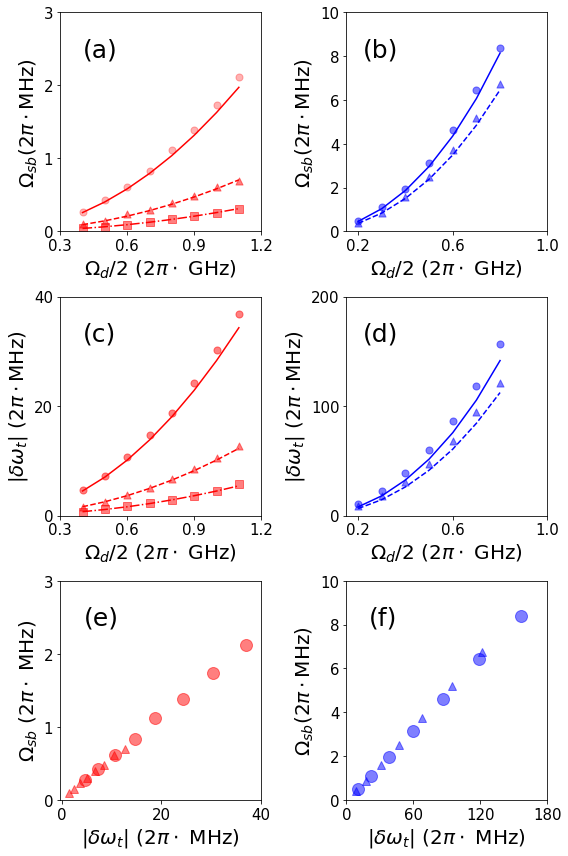

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(8,12))

plt.subplot(3, 2, 1)
plt.scatter(sim_eps_bs, sim_wsb_bs, c='r',label='Sim-Full',alpha=0.3, s=50 )
plt.scatter(sim_eps_bs_rwa, sim_wsb_bs_rwa, c='r',label='Sim-RWA', marker= "^",alpha=0.5, s=50)
plt.scatter(sim_eps_bs_cr, sim_wsb_bs_cr, c='r',label='Sim-CR', marker= "s",s=50, alpha=0.5)
plt.plot(sim_eps_bs, sim_wsb_th_bs, 'r-',label='Th-Full',alpha=1,  )
plt.plot(sim_eps_bs_rwa, sim_wsb_rwath_bs, 'r--',label='Th-RWA', )
plt.plot(sim_eps_bs_cr, sim_wsb_crth_bs, 'r-.',label='Th-CR',alpha=1,)
plt.xlim(0.3, 1.2)
plt.ylim([0, 3])
plt.yticks([0,1,2,3],fontsize=15)
plt.xticks([0.3,0.6,0.9,1.2],fontsize=15)
plt.text(0.4,3*8/10,'(a)',fontsize=25)
plt.ylabel(r'$\Omega_{{sb}}$($2 \pi\cdot$MHz)',fontsize=20)
plt.xlabel(r'$\Omega_d/2$ ($2\pi\cdot$ GHz)',fontsize=20)

plt.subplot(3, 2, 3)
plt.scatter(sim_eps_bs,  np.abs(1e3*sim_devdr_bs), c='r',edgecolors='r', label = 'Sim-Full', alpha=0.5, s=50)
plt.scatter(sim_eps_bs_rwa,   np.abs(1e3*sim_devdr_bs_rwa), c='r', edgecolors='r', s=50, label='Sim-RWA', marker= "^", alpha=0.5)
plt.scatter(sim_eps_bs_cr,   np.abs(1e3*sim_devdr_bs_cr), c='r', edgecolors='r', s=50, label='Sim-CR', marker= "s", alpha=0.5)
plt.plot(sim_eps_bs,  sim_devdr_bs_th, 'r-',label='Th-Full',alpha=1)
plt.plot(sim_eps_bs_rwa,  sim_devdr_bs_rwath, 'r--',label='Th-RWA',alpha=1)
plt.plot(sim_eps_bs_cr,  sim_devdr_bs_crth,'r-.',label='Th-CR',alpha=1)
plt.xlim(0.3, 0.8)
plt.ylim(0, 40)
plt.xticks([0.3,0.6,0.9,1.2],fontsize=15)
plt.yticks([0,20,40],fontsize=15)
plt.text(0.4,2*8*2,'(c)',fontsize=25)
plt.ylabel(r'|$\delta\omega_{t}|~(2 \pi\cdot$MHz)',fontsize=20)
plt.xlabel(r'$\Omega_d/2$ ($2\pi\cdot$ GHz)',fontsize=20)

plt.subplot(3, 2, 5)
plt.ylim([0,3])
plt.plot(-1e3*sim_devdr_bs_rwa,sim_wsb_bs_rwa,'r^',label='Sim-RWA',alpha=0.5,markersize=8)
plt.plot(-1e3*sim_devdr_bs, sim_wsb_bs,'ro', label = 'Sim-Full',alpha=0.5,markersize=12)
plt.xlabel(r'$|\delta\omega_{t}$| (2$\pi\cdot$ MHz)',fontsize=20)
plt.ylabel(r'$\Omega_{sb}$ ($2\pi\cdot$ MHz)',fontsize=20)
plt.xticks([0,20,40],fontsize=15)
plt.yticks([0,1,2,3],fontsize=15)
plt.text(20/4.5,3*8/10,'(e)',fontsize=25)

plt.subplot(3, 2, 2)
plt.scatter(sim_eps_tms, sim_wsb_tms, c='b', label='Sim-Full',alpha=0.5, s=50)
plt.scatter(sim_eps_tms_rwa, sim_wsb_tms_rwa, c='b',label='Sim-RWA',marker= "^",alpha=0.5, s=50)
plt.plot(sim_eps_tms, sim_wsb_th_tms, 'b-', label='Th-Full')
plt.plot(sim_eps_tms_rwa, sim_wsb_rwath_tms,'b--',label='Th-RWA')
plt.xlim(0.15, 0.9)
plt.ylim([0, 10])
plt.xticks([0.2,0.6,1.0],fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
plt.text(0.22,8,'(b)',fontsize=25)
plt.ylabel(r'$\Omega_{{sb}}$($2 \pi\cdot$MHz)',fontsize=20)
plt.xlabel(r'$\Omega_d/2$ ($2\pi\cdot$ GHz)',fontsize=20)

plt.subplot(3, 2, 4)
plt.scatter(sim_eps_tms, np.abs(1e3*sim_devdr_tms), c='b' ,edgecolors='b', label='Sim-Full',alpha=0.5, s=50)
plt.scatter(sim_eps_tms_rwa,   np.abs(1e3*sim_devdr_tms_rwa), c='b', edgecolors='b', s=50, label='Sim-RWA', marker= "^", alpha=0.5)
plt.plot(sim_eps_tms,  sim_devdr_tms_th,'b-' ,label='Th-Full',alpha=1)
plt.plot(sim_eps_tms_rwa,  sim_devdr_tms_rwath, 'b--',label='Th-RWA',alpha=1)
plt.xlim(0.15, 0.8)
plt.ylim(0,200)
plt.xticks([0.2,0.6,1.0],fontsize=15)
plt.yticks([0,100,200],fontsize=15)
plt.text(0.22,160,'(d)',fontsize=25)
plt.ylabel(r'|$\delta\omega_{t}|~(2 \pi\cdot$MHz)',fontsize=20)
plt.xlabel(r'$\Omega_d/2$ ($2\pi\cdot$ GHz)',fontsize=20)


plt.subplot(3, 2, 6)
plt.ylim([0,10])
plt.plot(-1e3*sim_devdr_tms_rwa, sim_wsb_tms_rwa,'b^',label='Sim-RWA',alpha=0.5,markersize=8)
plt.plot(-1e3*sim_devdr_tms, sim_wsb_tms,'bo',label='Sim-Full',alpha=0.5,markersize=12)
plt.xlabel(r'$|\delta\omega_{t}$| (2$\pi\cdot$ MHz)',fontsize=20)
plt.xticks([0,60,120,180],fontsize=15)
plt.yticks([0,2,4,6,8,10],fontsize=15)
plt.text(20,8,'(f)',fontsize=25)
plt.ylabel(r'$\Omega_{{sb}}$($2 \pi\cdot$MHz)',fontsize=20)

plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(top=0.7)
plt.tight_layout()
plt.show()